<a href="https://colab.research.google.com/github/benjamin-bertram/EvoGenTurbo/blob/main/EvoGen_Turbo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **EvoGen Turbo** 🐎
[Stable Diffusion](https://github.com/CompVis/stable-diffusion) by Robin Rombach, Andreas Blattmann, Dominik Lorenz, Patrick Esser, Björn Ommer and the [Stability.ai](https://stability.ai/) Team. [K Diffusion](https://github.com/crowsonkb/k-diffusion) by [Katherine Crowson](https://twitter.com/RiversHaveWings).

The aesthetics model that is an integral part of this method was made by [Katherine Crowson](https://twitter.com/RiversHaveWings) and can be found on her [Github account](https://github.com/crowsonkb/simulacra-aesthetic-models). Some parts of the CLIP guidance is also by her.

The baseline of the notebook, setup, description, and image generation, is based on the [EvoGen Prompt Evolution Notbook](https://colab.research.google.com/github/MagnusPetersen/EvoGen-Prompt-Evolution/blob/main/Notebook/EvoGen.ipynb) by [Magnus Petersen](https://twitter.com/Omorfiamorphism).

Adapted for SDXL-Turbo and SD-LCM by [Benjamin Bertram](https://www.linkedin.com/in/benjaminbertram/)

In [ ]:
#@title Setup
#@markdown First, please make sure you are using a GPU runtime to run this notebook, so generation is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.
from IPython.display import clear_output, display
#!pip install huggingface_hub==0.10.0 gradio
clear_output()

!pip install diffusers transformers accelerate

from diffusers import AutoPipelineForText2Image, DEISMultistepScheduler, LCMScheduler
import torch

#@markdown Choose your model_checkpoint. Note that you have to adjust the CFG Value and the number of steps accordingly (in the next section)
model_checkpoint = 'stabilityai/sdxl-turbo' #@param ['runwayml/stable-diffusion-v1-5','stabilityai/sdxl-turbo','lykon/dreamshaper-8', 'simianluo/lcm_dreamshaper_v7']
if model_checkpoint == 'simianluo/lcm_dreamshaper_v7':
    pipeline = AutoPipelineForText2Image.from_pretrained(model_checkpoint, torch_dtype=torch.float16).to("cuda")
    pipeline.scheduler = LCMScheduler.from_config(pipeline.scheduler.config)
else :
    pipeline = AutoPipelineForText2Image.from_pretrained(model_checkpoint, torch_dtype=torch.float16, variant="fp16").to("cuda")
    pipeline.scheduler = DEISMultistepScheduler.from_config(pipeline.scheduler.config)

clear_output()

#@markdown **Model and Output Paths**
# ask for the link
print("Local Path Variables:\n")

output_path = "/content/output" #@param {type:"string"}

#@markdown **Google Drive Path Variables (Optional)**
mount_google_drive = True #@param {type:"boolean"}
force_remount = False

if mount_google_drive:
    from google.colab import drive # type: ignore
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path,force_remount=force_remount)
        output_path_gdrive = "/content/drive/MyDrive/AI/StableDiffusion" #@param {type:"string"}
        output_path = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")

import os
import time
os.makedirs(output_path, exist_ok=True)

def get_output_folder(output_path, batch_folder):
    out_path = os.path.join(output_path,time.strftime('%Y-%m'))
    if batch_folder != "":
        out_path = os.path.join(out_path, batch_folder)
    os.makedirs(out_path, exist_ok=True)
    return out_path

print(f"output_path: {output_path}")



Local Path Variables:

Mounted at /content/drive
output_path: /content/drive/MyDrive/AI/StableDiffusion


In [ ]:
#@title Import required libraries
import numpy as np
import jax
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import pandas as pd
import os
import gc
import random
import requests
import io

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
! git clone https://github.com/MagnusPetersen/EvoGen-Prompt-Evolution.git
'''
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid
'''
def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

fatal: destination path 'EvoGen-Prompt-Evolution' already exists and is not an empty directory.


In [ ]:
#@title Aesthetics Helpers

#from torchvision.transforms import functional as TF
import torch.nn.functional as F

!git clone https://github.com/openai/CLIP
!git clone https://github.com/crowsonkb/simulacra-aesthetic-models
!pip install -e ./CLIP
import sys
sys.path.append('./CLIP')

import clip
from torchvision import transforms
import matplotlib.pyplot as plt

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

class AestheticMeanPredictionLinearModel(nn.Module):
    def __init__(self, feats_in):
        super().__init__()
        self.linear = nn.Linear(feats_in, 1)

    def forward(self, input):
        x = F.normalize(input, dim=-1) * input.shape[-1] ** 0.5
        return self.linear(x)

clip_model_name = 'ViT-B/16'
clip_model = clip.load(clip_model_name, jit=False, device=device)[0]
clip_model.eval().requires_grad_(False)

cutn = 32
make_cutouts = MakeCutouts(224, cutn)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

# 512 is embed dimension for ViT-B/16 CLIP
aes_model = AestheticMeanPredictionLinearModel(512)
aes_model.load_state_dict(
    torch.load("/content/simulacra-aesthetic-models/models/sac_public_2022_06_29_vit_b_16_linear.pth")
)

aes_model = aes_model.to(device)

artists = pd.read_csv('/content/EvoGen-Prompt-Evolution/Wordlists/artists.csv').dropna()
genres = pd.read_csv('/content/EvoGen-Prompt-Evolution/Wordlists/genres.csv').dropna()
words = pd.read_csv('/content/EvoGen-Prompt-Evolution/Wordlists/wordlist.csv').dropna()
words_aes = pd.read_csv('/content/EvoGen-Prompt-Evolution/Wordlists/wordsprompt.csv').dropna()
engrams_aes = pd.read_csv('/content/EvoGen-Prompt-Evolution/Wordlists/engramprompt.csv').dropna()


clear_output()

In [ ]:
#@title Evolution Helpers

class PromptGenerator:
    def __init__(self, population_count, prompt_length_max, prompt_length_min,
                 artist_prop, genre_prop, custom_prop, delete_prop, add_prop, mutate_prop,
                 shuffle_prop, cross_prop, k):
        self.artists = artists
        self.genres = genres
        if use_aes_words:
          self.words = words_aes
        if use_aes_engrams:
          self.words = engrams_aes
        if use_aes_words and use_aes_engrams:
          self.words = words_aes.append(engrams_aes)
        if use_aes_words == False and use_aes_engrams == False:
          self.words = words

        self.custom = custom
        self.population_count = population_count
        self.prompt_length_max = prompt_length_max
        self.prompt_length_min = prompt_length_min

        self.artist_prop = artist_prop
        self.genre_prop = genre_prop
        self.custom_prop = custom_prop

        self.word_prop = 1 - self.artist_prop - self.genre_prop
        self.delete_prop = delete_prop
        self.add_prop = add_prop

        self.mutate_prop = mutate_prop
        self.shuffle_prop = shuffle_prop
        self.cross_prop = cross_prop
        self.k = k

        self.fittness_history = []

    def initialize_prompt_population(self):
        #initialize the prompt population by randomly selecting words from artists, genres, and words dictionaries
        prompt_population = []
        for i in range(self.population_count):
            prompt = []
            for j in range(np.random.randint(self.prompt_length_min, self.prompt_length_max)):
                #pic based on artist_prop, genre_prop, and word_prop probabilities which dataframe to select from
                rand_num = np.random.random()
                if rand_num < self.artist_prop:
                    prompt.append(self.artists.sample(1).artist.values[0])
                elif rand_num < self.artist_prop + self.genre_prop:
                    prompt.append(self.genres.sample(1).genre.values[0])
                elif rand_num < self.artist_prop + self.genre_prop + self.custom_prop:
                    prompt.append(self.custom.sample(1).custom.values[0])
                else:
                    prompt.append(self.words.sample(1).word.values[0])
            prompt_population.append(prompt)
        self.prompt_population = prompt_population

    def selection(self, scores):
        selection_ix = np.random.randint(self.population_count)
        for ix in np.random.randint(0, self.population_count, self.k-1):
            if scores[ix] > scores[selection_ix]:
                selection_ix = ix
        return self.prompt_population[selection_ix]

    def cross_over(self, prompt_1, prompt_2):
        c1, c2 = prompt_1, prompt_2
        rand_num = np.random.random()
        if rand_num < self.cross_prop:
            if len(prompt_2) ==0:
              prompt_index = 0
            else:
              prompt_index = np.random.randint(0, min(len(prompt_1), len(prompt_2)))
            c1 = prompt_1[:prompt_index] + prompt_2[prompt_index:]
            c2 = prompt_2[:prompt_index] + prompt_1[prompt_index:]
        return [c1, c2]

    def mutate_prompts(self, prompt):
        if (len(prompt) == 0):
          prompt_index = 0
          rand_num = np.random.random()
          if rand_num < self.artist_prop:
              prompt.insert(prompt_index, self.artists.sample(1).artist.values[0])
          elif rand_num < self.artist_prop + self.genre_prop:
              prompt.insert(prompt_index, self.genres.sample(1).genre.values[0])
          elif rand_num < self.artist_prop + self.genre_prop + self.custom_prop:
              prompt.insert(prompt_index, self.custom.sample(1).custom.values[0])
          else:
              prompt.insert(prompt_index, self.words.sample(1).word.values[0])

        for i in range(len(prompt)):
            rand_num = np.random.random()
            if rand_num < self.mutate_prop:
                rand_num = np.random.random()
                if rand_num < self.artist_prop:
                    prompt[i] = self.artists.sample(1).artist.values[0]
                elif rand_num < self.artist_prop + self.genre_prop:
                    prompt[i] = self.genres.sample(1).genre.values[0]
                elif rand_num < self.artist_prop + self.genre_prop + self.custom_prop:
                    prompt[i] = self.custom.sample(1).custom.values[0]
                else:
                    prompt[i] = self.words.sample(1).word.values[0]


        delete_count = np.random.binomial(len(prompt), self.delete_prop)
        if len(prompt) - delete_count < 2:
            delete_count = len(prompt) - 2

        prompt = np.delete(prompt, np.random.randint(len(prompt), size=delete_count)).tolist()

        for i in range(len(prompt)):
            rand_num = np.random.random()
            if rand_num < self.add_prop:
                rand_num = np.random.random()
                if rand_num < self.artist_prop:
                    prompt.insert(i, self.artists.sample(1).artist.values[0])
                elif rand_num < self.artist_prop + self.genre_prop:
                    prompt.insert(i, self.genres.sample(1).genre.values[0])
                elif rand_num < self.artist_prop + self.genre_prop + self.custom_prop:
                    prompt.insert(i, self.custom.sample(1).custom.values[0])
                else:
                    prompt.insert(i, self.words.sample(1).word.values[0])

        rand_num = np.random.random()
        if rand_num < self.shuffle_prop:
            prompt = np.random.permutation(prompt).tolist()

        return prompt

    def create_next_generation(self, scores):
        selected = [self.selection(scores) for _ in range(self.population_count)]
        children = []
        for i in range(0, self.population_count, 2):
            prompt_1, prompt_2 = selected[i], selected[i+1]
            for c in self.cross_over(prompt_1, prompt_2):
                c = self.mutate_prompts(c)
                children.append(c)

        filtered_children = []
        for elem in children:
            if elem not in filtered_children:
                filtered_children.append(elem)

        children = filtered_children

        missing_prompts = self.population_count - len(children)
        print("The following number of duplicate prompts had to be replaced with random ones:"+str(missing_prompts))
        for i in range(missing_prompts):
            prompt = []
            for j in range(np.random.randint(self.prompt_length_min, self.prompt_length_max)):
                rand_num = np.random.random()
                if rand_num < self.artist_prop:
                    prompt.append(self.artists.sample(1).artist.values[0])
                elif rand_num < self.artist_prop + self.genre_prop:
                    prompt.append(self.genres.sample(1).genre.values[0])
                else:
                    prompt.append(self.words.sample(1).word.values[0])
            children.append(prompt)

        self.prompt_population = children

    def population_as_string(self):
        return [' '.join(prompt) for prompt in self.prompt_population]

In [ ]:
#Create your custom word list from which the evolutionary algorithm samples words. You can set a sampling probability but can also enforce a certain number of these words to be in the prompts.
custom_words = ["Beepcloud", "CatchPlace", "MarketMagic", "Brainism", "Cloudnomy", "Wizardpanion", "Infinlearn", "EnNet", "Datazism", "EnWizard", "ByteIntelligence", "Shapecron", "Cloudserv", "Cotoy", "Enhancetoy", "Neuralcron", "Demiai", "AiMagic", "LifeMatrix", "ElectricBazar", "28", "8flow", "Bytenomy", "Digicompanion", "Formco", "Aidty", "DemiIntelligence", "Createtoy", "4Dai", "Sensaid", "Lifeform", "Wizardco", "EnhanceBrain", "SynWizard", "Enhanceaid", "Syntoy", "2Mind", "4gen", "SensBrain", "Flowfine", "Senstoy", "Market8", "Designcomplex", "Place64", "Metachron", "Entinomy", "RedNet", "Placeart", "Nautitron", "Infinism", "Enhancecompanion", "SensCloud", "Entilearn", "Elecomplex", "SensFactory", "Servcompanion", "4learn", "Beepshape", "Idata", "Entiverse", "3Dfine", "Ilus", "Modelform", "2co", "UniverseNet", "Castism", "Eleshape", "ElectricMagic", "Placeverse", "Bazarium", "Cloudlus", "Design8", "Electriccloud", "IntelliBrain", "CastAI", "Refinecloud", "Digitalflow", "Designbit", "Eleium", "Servbit", "Placemo", "RedAI", "Flowium", "DesignMetric", "FormBrain", "Bluewerk", "Greenzism", "Datalus", "4zism", "NeuroCarpet", "Itoy", "Bluecompanion", "ShapeMagic", "Redart", "Geometricintelli", "Wizardpanion", "Diaaid", "Geometric64", "Ire", "Dreamlearn", "4shape", "4Ddata", "Marketcompanion", "ModelCarpet", "FineFactory", "RedWerk", "Tensorty", "Nodelearn", "GeometricCarpet", "Digitalgen", "EntiDrop", "ByteMarket", "Entiism", "Entinet", "Completeory", "Cogniium", "IntelliWizard", "ElectricWerk", "Entiwerk", "Placepanion"]
custom = pd.DataFrame(custom_words, columns=["custom"])

In [ ]:
#@markdown **Evolutionary Algorithm Settings**

#@markdown General population settings, such as how many generations the algorithm runs for, how many prompts there are in each generation, and the word length range of the prompts.
generations = 15 #@param
n_samples = 8
population_count = 200 #@param
population_count = int(n_samples*(population_count//n_samples + 1))
prompt_length_max = 15 #@param
prompt_length_min = 3 #@param
#@markdown Probability to sample from one of the word lists when adding or mutating a word. The difference between the sum of the three custom lists and 1 is the probability to sample from the English dictionary word list.
artist_prop = 0 #@param
genre_prop = 0 #@param
custom_prop = 1 #@param
#@markdown require_custom_words turns the custom_words_list into a list where a given number of words from that list, determined by min_custom_words, have to be included in the prompts.
require_custom_words  = True #@param {type:"boolean"}
min_custom_words = 20 #@param
#@markdown Decide which list to use if the genre, custom and artists list are not selected from sampling. Use either a list from high scoring prompts, 2/3-grams of those prompts of both. If none are selected use a complete english dictionary.
use_aes_words = False #@param {type:"boolean"}
use_aes_engrams = False #@param {type:"boolean"}
#@markdown Generation evolution settings including the probability to delete, add and swap out each word for a new one from the dictionary.
delete_prop = 0.1 #@param
add_prop = 0.105 #@param
mutate_prop = 0.15 #@param
shuffle_prop = 0.1 #@param
#@markdown Generation evolution settings for the new generation parent selection and breeding. The cross-over probability is the probability of the parents swapping prompt parts. K denotes the rounds in the tournament selection process. A higher K value means fewer parents generate the next generation, this means a higher score increase but less diversity in the prompts.
cross_prop = 0.8 #@param
k = 6 #@param
#@markdown Cutoff score to save the image and prompt and display it.
cutoff = 7 #@param
#@markdown True if you want to guide the evolution with an additional prompt and not just aesthetics
use_prompt = False #@param {type:"boolean"}
prompt = "A quick brown fox jumps over the lazy robot" #@param {type:"string"}
if use_prompt:
  encoding_txt = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()
#@markdown True if you want to guide the evolution with an additional image prompt and not just aesthetics
use_img = False #@param {type:"boolean"}
img_url = "https://images.lookhuman.com/render/standard/iMkSjDDGqxUwxKjOymbXzE9nQKoGiBl2/diecut-whi-z1-t-yeet-nasa-logo-parody.jpg" #@param {type:"string"}
if use_img:
  img = Image.open(fetch(img_url)).convert('RGB')
  img = TF.resize(img, min(224, 224, *img.size), transforms.InterpolationMode.LANCZOS)
  batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
  encoding_img = clip_model.encode_image(normalize(batch)).float()
#@markdown The weight of prompt & image prompt. For instance 0.6 means the score is the result of 60% prompt+image prompt and 40% aesthetics
prompt_weigth = 1.3 #@param
#@markdown **Save & Display Settings**
batch_name = "StableEvoImgPromptV1" #@param {type:"string"}
outdir = get_output_folder(output_path, batch_name)
save_samples = False #@param {type:"boolean"}

#@markdown **Image Settings**
W = 768 #@param
H = 512 #@param
W, H = map(lambda x: x - x % 64, (W, H))  # resize to integer multiple of 64

#@markdown **Sampling Settings**
num_inference_steps = 1 #@param {type:"integer"}
seed = -1 #@param {type:"integer"}
CFG = 0.0 #@param
#@markdown `-1` will set a random seed. You can replace that to any integer for reproducible results

def filtered_with_scores(special_cos_dist, cos_dist, images, safety_model_params):
  return images, [False]
#pipeline.safety_checker.filtered_with_scores = filtered_with_scores

n_samples = jax.device_count()

prompt_generator = PromptGenerator(population_count, prompt_length_max, prompt_length_min,
                                  artist_prop, genre_prop, custom_prop, delete_prop, add_prop, mutate_prop,
                                  shuffle_prop, cross_prop, k)
prompt_generator.initialize_prompt_population()

mean_score = []
mean_loss_prompt = []
best_score = []
mean_prompt_length = []

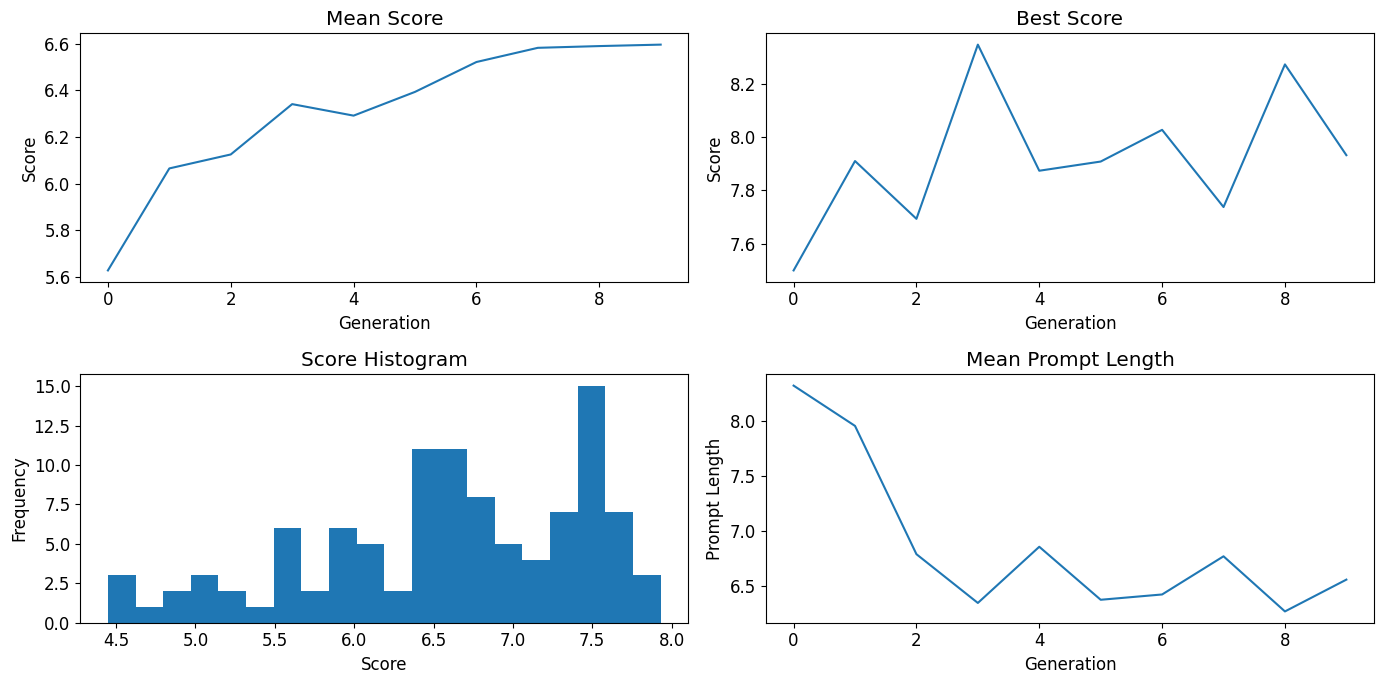

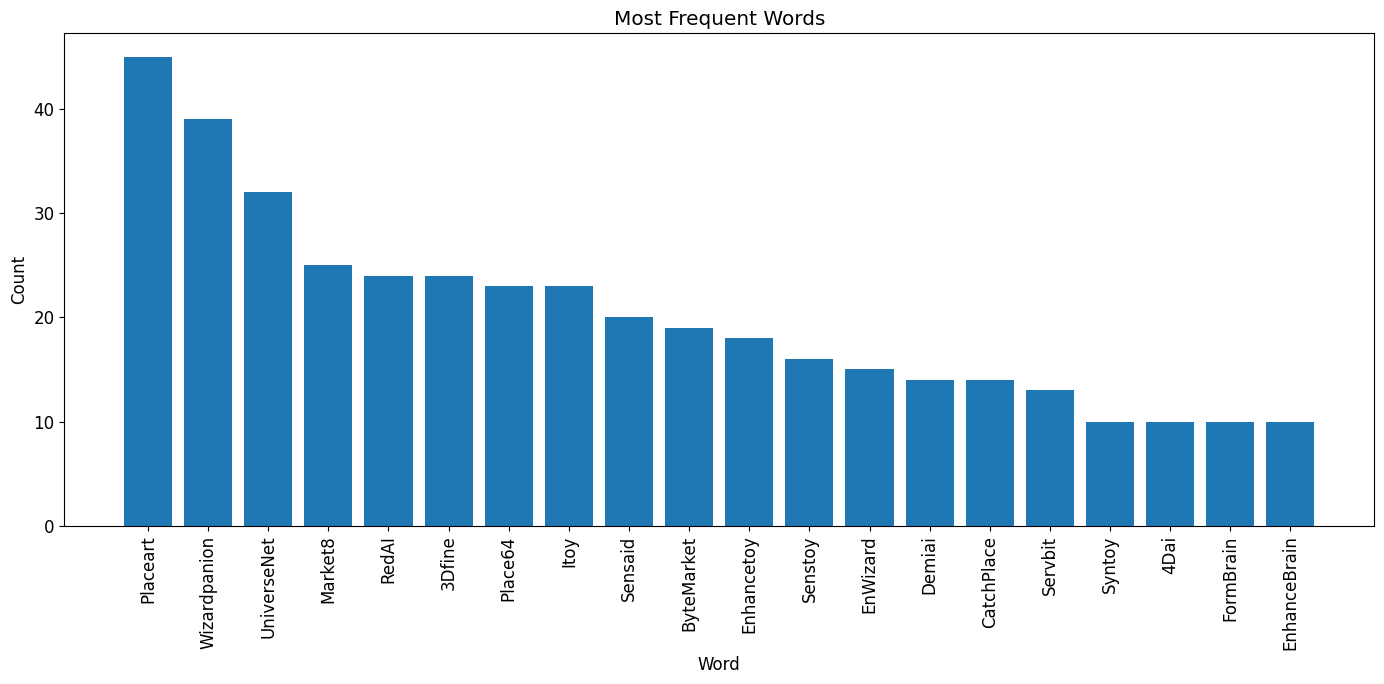

EnWizard Placeart Wizardpanion Placeverse Sensaid Market8 UniverseNet
EnNet Wizardpanion Itoy Market8 Placeart Wizardco
Placeart CastAI Servcompanion 3Dfine 4gen Cloudnomy Wizardpanion
Market8 Shapecron Wizardpanion UniverseNet Sensaid Placeart
RedAI Bazarium Bytenomy
28 Demiai Servbit Enhanceaid Cloudlus Place64
RedAI Senstoy Eleium CatchPlace Servbit Refinecloud Place64 Cotoy Wizardpanion Redart FormBrain
EntiDrop 28 4Dai Placeart ByteMarket Refinecloud Place64 Cotoy Wizardpanion FormBrain
RedAI 4Dai ByteMarket Place64


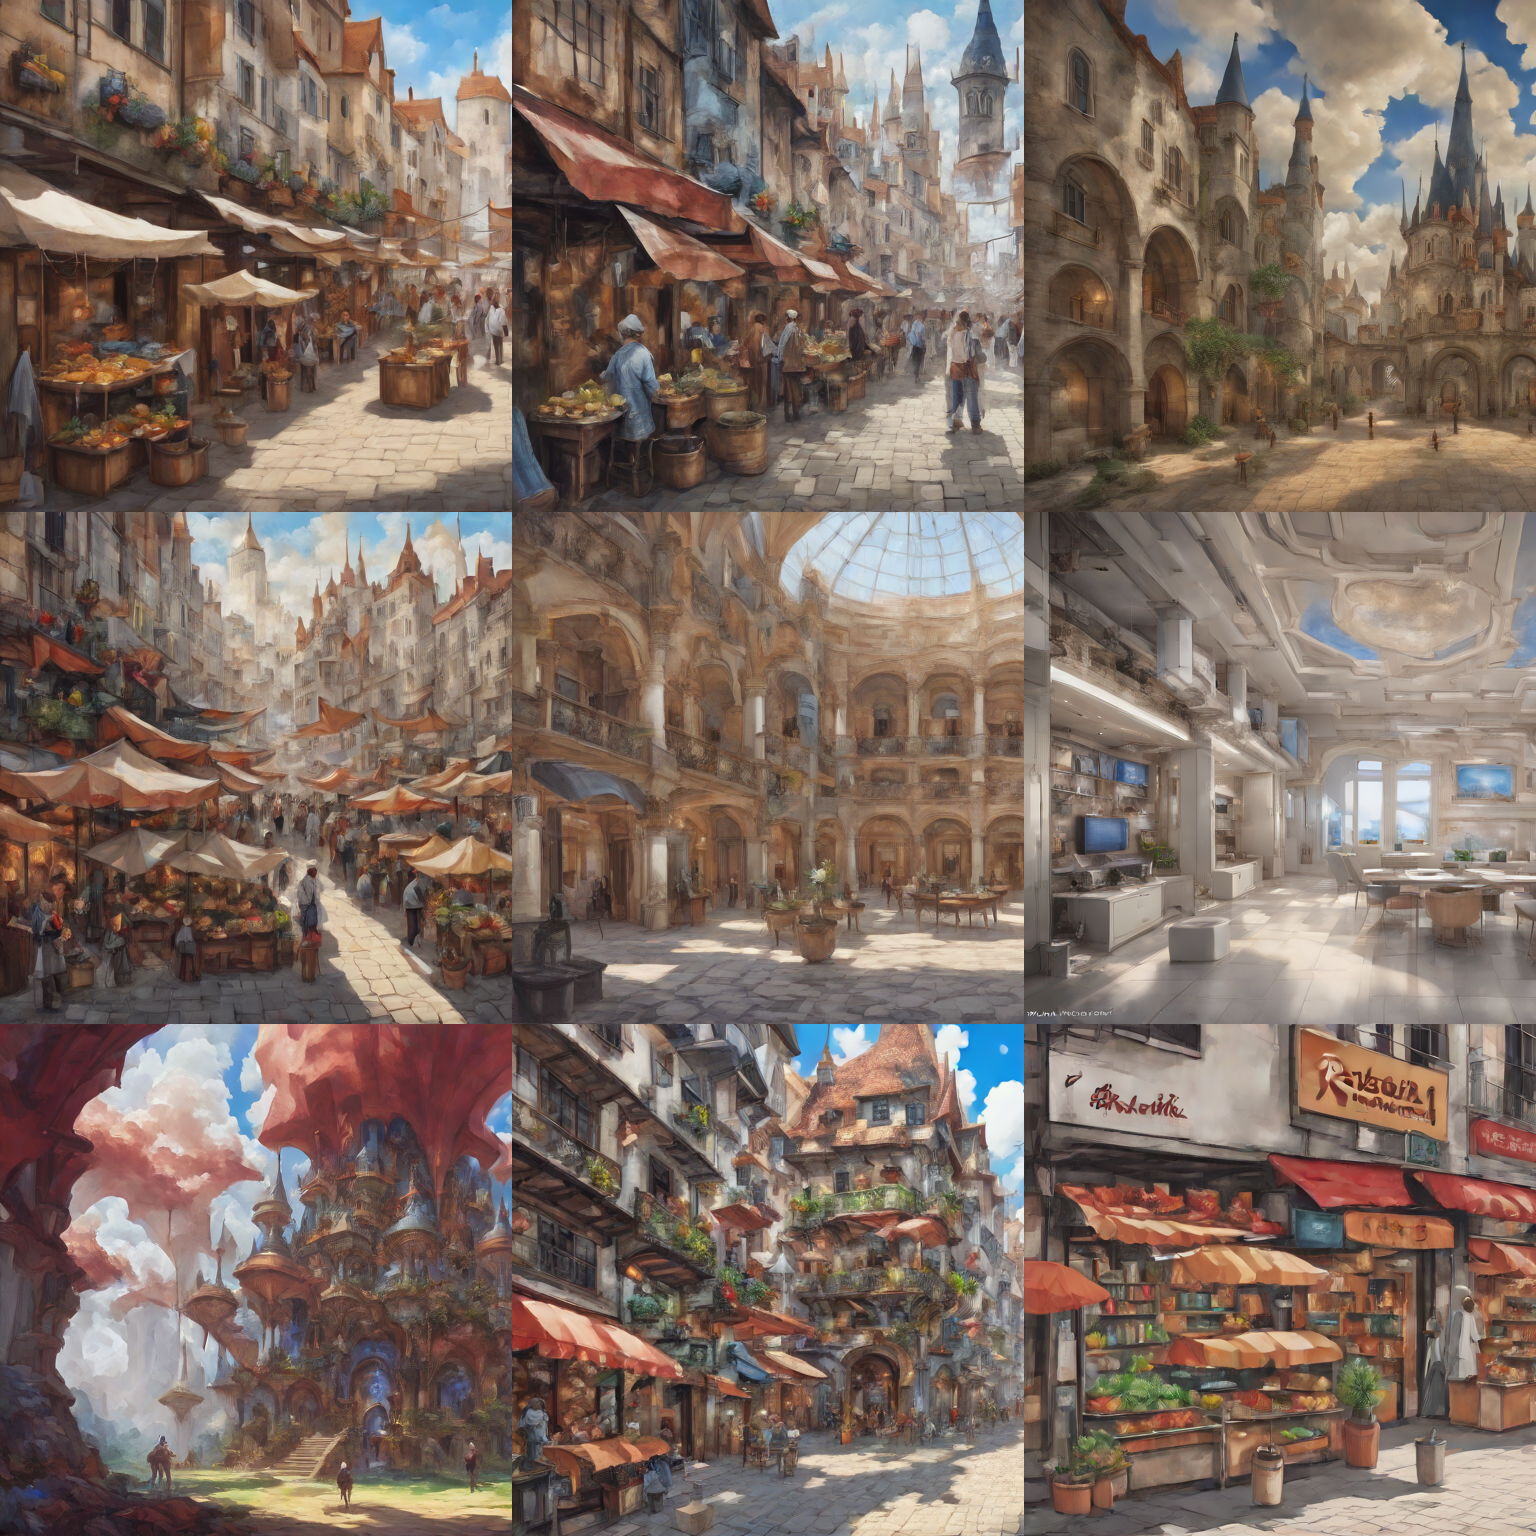

The following number of duplicate prompts had to be replaced with random ones:3


In [ ]:
#@title Evolution Loop

def plot_fittness_history():
  plt.figure(figsize=(14,7))
  plt.rcParams.update({'font.size': 12})
  plt.subplot(2,2,1)
  plt.plot(mean_score)
  plt.title("Mean Score")
  plt.xlabel("Generation")
  plt.ylabel("Score")
  plt.subplot(2,2,2)
  plt.plot(best_score)
  plt.title("Best Score")
  plt.xlabel("Generation")
  plt.ylabel("Score")
  plt.subplot(2,2,3)
  plt.hist(scores[::, 0], bins=20)
  plt.title("Score Histogram")
  plt.xlabel("Score")
  plt.ylabel("Frequency")
  plt.subplot(2,2,4)
  plt.plot(mean_prompt_length)
  plt.title("Mean Prompt Length")
  plt.xlabel("Generation")
  plt.ylabel("Prompt Length")
  plt.tight_layout()
  if use_prompt or use_img:
    plt.figure(figsize=(14,3))
    plt.rcParams.update({'font.size': 12})
    plt.subplot(1,1,1)
    #plot the mean prompt score over time
    plt.plot(mean_loss_prompt)
    plt.title("Prompt Loss")
    plt.xlabel("Generation")
    plt.ylabel("Loss")
    plt.tight_layout()
  plt.figure(figsize=(14,7))
  plt.rcParams.update({'font.size': 12})
  plt.subplot(1,1,1)
  plt.bar(most_frequent_words.word, most_frequent_words.frequency)
  plt.xticks(rotation=90)
  plt.title("Most Frequent Words")
  plt.xlabel("Word")
  plt.ylabel("Count")
  plt.tight_layout()
  plt.show()
  #plt.savefig(os.path.join(gen_path, "graph.png"))

def plot_top_9():
    top_9idx = torch.flip(np.argsort(scores)[-9:], (0,)).tolist()
    print(*[prompts[i] for i in top_9idx], sep="\n")
    with open(os.path.join(gen_path, "best_9_prompts.txt"), 'w') as f:
        f.write('\n'.join([prompts[i] for i in top_9idx]))

    # Create a grid of images
    grid_width = 3
    grid_height = 3
    image_size = 512  # Assuming each image is 512x512
    grid = Image.new('RGB', (image_size * grid_width, image_size * grid_height))

    for idx, image_idx in enumerate(top_9idx):
        # Convert tensor to PIL image
        image_tensor = image_population[image_idx].cpu()
        image_tensor = image_tensor / 255.0
        image = transforms.ToPILImage()(image_tensor)
        # Calculate grid position
        x = idx % grid_width * image_size
        y = idx // grid_width * image_size
        grid.paste(image, (x, y))

    display(grid)
    grid.save(os.path.join(gen_path, "best_9.png"))

def shard_and_gen_images(prompts):
  if(seed == -1):
    random_int = random.randint(0, 2147483647)
    real_seed = random_int
  else:
    real_seed = seed
  images = pipeline(prompt=prompts, guidance_scale=CFG, num_inference_steps=num_inference_steps, seed=real_seed, height=H, width=W).images
  return images, real_seed

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

def fittness_function(images):
    clip_preped_images = torch.zeros(size=(n_samples, 3, 224, 224), device=device)
    for i in range(len(images)):
        img = TF.resize(images[i], 224, transforms.InterpolationMode.LANCZOS)
        img = TF.center_crop(img, (224,224))
        img = TF.to_tensor(img).to(device)
        img = normalize(img)
        clip_preped_images[i] = img

    clip_image_embed = F.normalize(
        clip_model.encode_image(clip_preped_images).float(),
        dim=-1)

    scores = aes_model(clip_image_embed).mean(axis=1)
    clip_score = torch.zeros(size=(n_samples,), device=device)

    if use_prompt:
        dists = spherical_dist_loss(clip_image_embed.unsqueeze(1), encoding_txt.unsqueeze(0))
        dists = dists.view([1, n_samples, -1])
        clip_score += dists.sum(2).mean(0)

    if use_img:
        dists = spherical_dist_loss(clip_image_embed.unsqueeze(1), encoding_img.unsqueeze(0))
        dists = dists.view([cutn, n_samples, -1])
        clip_score += dists.sum(2).mean(0)

    return scores, clip_score


with torch.no_grad():
  for i in range(generations):
    gen_path = get_output_folder(output_path, batch_name)+'/gen_'+str(i)
    os.makedirs(gen_path, exist_ok=True)
    os.makedirs(gen_path+"/best", exist_ok=True)

    prompts = prompt_generator.population_as_string()
    image_population = torch.zeros(size = (prompt_generator.population_count, 3, H, W))
    scores = torch.zeros(prompt_generator.population_count, 2)
    displayed_img_count = 0

    for j in range(0, prompt_generator.population_count, n_samples):
      gc.collect()
      torch.cuda.empty_cache()

      images, current_seed = shard_and_gen_images(prompts[j:(j+n_samples)])
      images_array = np.array([np.asarray(image) for image in images])

      images_pil = [Image.fromarray(255 - (img * 255).astype(np.uint8)) for img in images_array]

      aes_score, prompt_score = fittness_function(images_pil)
      scores[j:(j+n_samples), 0] = aes_score
      scores[j:(j+n_samples), 1] = prompt_score

      for k in range(len(images)):
        image_population[j+k] = torch.tensor(np.float32(images[k])).permute([2, 0, 1])

        if save_samples:
            filename = prompts[j+k]+".png"
            images_pil[k].save(os.path.join(gen_path, filename))

        if scores[j+k, 0] >= cutoff:
          filename_length = min(150, len(prompts[j+k]))
          images_pil[k].save(gen_path+'/best/'+prompts[j+k][:filename_length]+'.png')
          with open(gen_path+'/best/'+prompts[j+k][:filename_length]+'.txt', 'w') as f:
            f.write(prompts[j+k])
            f.write('\n')
            f.write(str(current_seed))
          if save_samples == False:
            print(prompts[j+k])
            display(images_pil[k])
            displayed_img_count += 1
            if displayed_img_count >= 32:
              clear_output(wait=True)
              displayed_img_count = 0

    clear_output(wait=True)
    mean_score.append(scores[::, 0].mean().item())
    mean_loss_prompt.append(scores[::, 1].mean().item())
    best_score.append(max(scores[::, 0]).item())
    mean_prompt_length.append(np.mean([len(prompt) for prompt in prompt_generator.prompt_population]))
    most_frequent_words = pd.DataFrame(sum(prompt_generator.prompt_population, []), columns = ['word']).word.value_counts().head(20).reset_index()
    most_frequent_words.columns = ['word', 'frequency']

    plot_fittness_history()
    if use_prompt or use_img:
      scores[::, 0] = (scores[::, 0] - scores[::, 0].min()) / (scores[::, 0].max() - scores[::, 0].min())
      scores[::, 1] = torch.abs((scores[::, 1] - scores[::, 1].min()) / (scores[::, 1].max() - scores[::, 1].min()) - 1)
      scores = prompt_weigth*scores[::, 0] + (1-prompt_weigth)*scores[::, 1]
    else:
      scores = scores[::, 0]
    plot_top_9()

    prompt_generator.create_next_generation(scores)